In [1]:
import gdown
import zipfile
import os
import sys
from pathlib import Path

data_folder = Path('data')
if not data_folder.exists():
    data_folder.mkdir()

dataset_folder = data_folder / 'dataset_v2'
if not dataset_folder.exists():    
    dataset_folder.mkdir()

nasa_datasets_folder = Path('nasa_datasets')
cumulative_dataset_path = nasa_datasets_folder / 'cumulative_koi.csv'
dataset_control_path = dataset_folder / 'dataset_ctrl.parquet'


In [2]:
import pandas as pd

df_cumulative = pd.read_csv(cumulative_dataset_path.resolve())

# separando as analises de planetas confirmados com confiança > 99%
df_conf = df_cumulative.groupby('kepid').filter(lambda group: (group['koi_disposition'] == 'CONFIRMED').all() and (group['koi_score'] > 0.99).all())

# separando as analises de planetas falsos positivos com confiança > 99%
df_fls_pos = df_cumulative.groupby('kepid').filter(lambda group: (group['koi_disposition'] == 'FALSE POSITIVE').all() and (group['koi_score'] < 0.01).all())

# Separando uma lista somente kepler id de CONFIRMADOS e outra com FALSO POSITIVOS
conf_list = df_conf['kepid'].unique().tolist()
fls_pos_list = df_fls_pos['kepid'].unique().tolist()

print(f'Sistemas com planetas confirmados {len(conf_list)}')
print(f'Sistemas sem planetas confirmados {len(fls_pos_list)}')


Sistemas com planetas confirmados 1209
Sistemas sem planetas confirmados 3386


In [3]:
# recebe o tamanho da menor lista
dataset_len = len(conf_list) if len(conf_list) < len(fls_pos_list) else len(fls_pos_list)
print(f'Tamanho da menor lista {dataset_len}')

Tamanho da menor lista 1209


In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from lightkurve import search_targetpixelfile
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import traceback
import warnings

warnings.filterwarnings('ignore')


def fill_nan_pixel_file(px):
    """
        Preenche os pixels NAN's de uma imagem 4 x 5 pixels, com a média dos pixels em seu entorno
    """
    shp = px.shape

    nan_idx = np.where(np.isnan(px))

    for idx in range(len(nan_idx[0])):

        x = nan_idx[1][idx]
        y = nan_idx[0][idx]

        sum_px = 0
        count = 0

        if x > 0: # left
            if not np.isnan(px[y][x-1]):
                sum_px += px[y][x-1]
                count += 1

        if x < (shp[1]-1): # right
            if not np.isnan(px[y][x+1]):
                sum_px += px[y][x+1]
                count += 1

        if y > 0: # up
            if not np.isnan(px[y-1][x]):
                sum_px += px[y-1][x]
                count += 1

        if y < (shp[0]-1): # down
            if not np.isnan(px[y+1][x]):
                sum_px += px[y+1][x]
                count += 1

        if count > 0:
            px[y][x] = sum_px / count

    return px


def identify_outliers(df):
    """
      Identifica os valores outliers baseado nos quartis de um dataframe pandas e retorna uma serie contendo seus indices
    """
    q1 = df.describe().loc['25%', :]
    q3 = df.describe().loc['75%', :]
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    outliers_idx = df.loc[(df > upper_bound).any(axis=1)].index

    return outliers_idx


def serie_len_reduction(serie, ds_len=1000):
    """
        Reduz o comprimento de uma serie utilizando interpolação cúbica
    """
    data = serie[np.isfinite(serie)]
    f = interp1d(np.arange(len(data)), data, kind='cubic')
    idx = np.linspace(0, len(data) - 1, ds_len)

    return f(idx)


def pixel_file_resize(pixel_array:np.array, new_shape:tuple):
    """
        Altera o shape da imagem utilizando interpolação cúbica
    """

    interp_func = interp2d(np.arange(pixel_array.shape[1]), np.arange(pixel_array.shape[0]), pixel_array, kind='linear')
    x_new = np.linspace(0, pixel_array.shape[1] - 1, new_shape[1])
    y_new = np.linspace(0, pixel_array.shape[0] - 1, new_shape[0])

    return interp_func(x_new, y_new)


def simple_detrending(data: np.array):
    """
        Remove a tendencia de um sinal
    """
    idx = np.linspace(0, len(data) - 1, len(data))
    coef = np.polyfit(idx, data, 10)
    trending = np.polyval(coef, idx)
    return data - trending


def quarter_flux_slicer(quarter, slice_len):
    df_type = {f'px{n}': 'float32' for n in range(25)}
    df_type['sap'] = 'float32'
    df_type['quarter_idx'] = 'uint16'
    df_type['quarter'] = 'uint16'

    quarter_idx = 0
    
    flux_val = quarter.flux.value

    if len(flux_val) < slice_len:
        return None

    print(f' {quarter.quarter}', end='')
    
    # passa por cada frame
    lst = []
    for f in flux_val:

        # frames com mais de 3 pixels nulos são descartados
        if np.isnan(f).sum() > 3:
            # preenche com nulos para depois serem removidos junto com
            # a curva de luz correspondente
            lst.append([None]*25)
            continue
            
        # preenche os pixels NaN's com a média dos pixels ao redor
        ff = fill_nan_pixel_file(f)
        
        # padroniza o tamanho da imagem para (5x5) com interpolação
        if ff.shape != (5, 5):
            ff = pixel_file_resize(ff, (5,5))
        
        # adiciona na fila o array unidimensional
        lst.append(list(ff.flatten()))

    # cria o dataframe com os 25 pixels
    df = pd.DataFrame(lst, columns=[f'px{px}' for px in range(25)])
    
    # adiciona a curva de luz
    lc = quarter.to_lightcurve(aperture_mask=quarter.pipeline_mask).flatten()
    df['sap'] = lc.flux.value
    
    # dropa outliers
    idx = identify_outliers(df)
    df.drop(idx, inplace=True)

    # Indices nas linhas de frames descartados
    # para serem levados em conta na separação
    # dos lotes
    nan_idx = df[df.isna().any(axis=1)].index
    
    start = 0
    end = 0

    # se houverem registros nulos, faz um processo de separação
    # dos pedaços continuos de registros com tamanho slice_len
    if nan_idx.any():
        # passa pelos indices de registros nulos
        for idx in range(1, len(nan_idx)):
            # verifica se os intervalos entre os indices nulos
            # são maiores que slice_len
            frames_num = nan_idx[idx] - nan_idx[idx-1]
            if frames_num >= slice_len:
                # verifica quantos lotes cabem no intervalo
                # entre os registros nulos
                slices_num = frames_num // slice_len
                begin = nan_idx[idx-1]
                
                # quebra o intervalo em pedaços de slice_len                
                for i in range(slices_num):
                    start = begin + (i * slice_len)
                    end = start + slice_len
                    
                    df_slice = df.iloc[start:end].reset_index()
                    df_slice['quarter_idx'] = [quarter_idx] * len(df_slice)
                    df_slice['quarter'] = [quarter.quarter] * len(df_slice)
                    df_slice = df_slice.astype(df_type)
                    yield df_slice
    else:
        slices_num = len(df) // slice_len
        
        # quebra o intervalo em pedaços de slice_len                
        for i in range(slices_num):
            quarter_idx += 1
            start = i * slice_len
            end = start + slice_len
            
            df_slice = df.iloc[start:end].reset_index()
            df_slice['quarter_idx'] = [quarter_idx] * len(df_slice)
            df_slice['quarter'] = [quarter.quarter] * len(df_slice)
            df_slice = df_slice.astype(df_type)
            yield df_slice


def save_quarter_dataframe(kepid, quarter, disposition, ds_len):
    # se houver algum erro com o fluxo do quartil 
    # não pode prosseguir
    if quarter.flux is None:
        return

    count = 0

    flux_slicer = quarter_flux_slicer(quarter, ds_len)
    
    q_n = quarter.quarter
    
    # pedaços de ds_len registros
    for fl in flux_slicer:
        dataset_path = dataset_folder / f'{kepid}.parquet'
        
        if dataset_path.exists():
            df = pd.read_parquet(dataset_path.resolve())
            df = pd.concat([df, fl], ignore_index=True)
            df.to_parquet(dataset_path.resolve())
        else:
            fl.to_parquet(dataset_path.resolve())
            
        count += 1
        
    return count

def save_kepid_datasets(kepid, disposition, ds_len = 1000):

    # colunas do dataset de controle
    ctrl_columns = ['kepid', 'quarter', 'status', 'status_desc']

    print(f'KEPID {kepid} Disposition {disposition}')
    
    q_lst = []
    if dataset_control_path.exists():
        ctrl_df = pd.read_parquet(dataset_control_path.resolve())
        q_lst = ctrl_df[ctrl_df['kepid'] == kepid]['quarter'].tolist()
    else:
        ctrl_df = pd.DataFrame()
    
    pf_lst = search_targetpixelfile(str(kepid), author='kepler', cadence='long').download_all()

    print(f'{kepid} {disposition} retornou {len(pf_lst)} quartis')
    count = 0
    
    print('Quartil', end='')
    
    #passa por todos os quartis
    for quarter in pf_lst:
        if quarter.quarter in q_lst:
            continue
        
        try:
            count += save_quarter_dataframe(kepid, quarter, disposition, ds_len)
            ctrl_df = pd.concat([ctrl_df, pd.DataFrame([[kepid, quarter.quarter, 'success', '']], columns=ctrl_columns)], ignore_index=True)
            
        except KeyboardInterrupt:
            print('codigo interrompido')
            return 'break'
            
        except:
            print(f'falhou false p {traceback.format_exc()}')
            ctrl_df = pd.concat([ctrl_df, pd.DataFrame([[kepid, quarter.quarter, 'failed', traceback.format_exc()]], columns=ctrl_columns)], ignore_index=True)
        
        ctrl_df.to_parquet(dataset_control_path.resolve())
    if count == 0:
        print(f'\nObjeto de interesse {kepid} já foi processado anteriormente\n')
    else:
        print(f'\nDo objeto de interesse {kepid}, foram salvos {count} pedaços de quartis\n')
    return 'ok'

In [5]:
# teste
# if dataset_control_path.exists():
    # dataset_control_path.unlink()

kepid = 6922244
save_kepid_datasets(kepid, 'CONFD')

df = pd.read_parquet('data/dataset_v2/6922244.parquet')
df.info()

KEPID 6922244 Disposition CONFD
6922244 CONFD retornou 18 quartis
Quartil
Objeto de interesse 6922244 já foi processado anteriormente

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44000 entries, 0 to 43999
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        44000 non-null  int64  
 1   px0          44000 non-null  float32
 2   px1          44000 non-null  float32
 3   px2          44000 non-null  float32
 4   px3          44000 non-null  float32
 5   px4          44000 non-null  float32
 6   px5          44000 non-null  float32
 7   px6          44000 non-null  float32
 8   px7          44000 non-null  float32
 9   px8          44000 non-null  float32
 10  px9          44000 non-null  float32
 11  px10         44000 non-null  float32
 12  px11         44000 non-null  float32
 13  px12         44000 non-null  float32
 14  px13         44000 non-null  float32
 15  px14         44000 non-null  float32


In [6]:
df.head()

,index,px0,px1,px2,px3,px4,px5,px6,px7,px8,...,px18,px19,px20,px21,px22,px23,px24,sap,quarter_idx,quarter
0,0,6.214707,90.362671,493.608337,502.182800,138.814117,25.667660,1223.971313,4839.479980,2903.370850,...,928.748108,106.506500,126.293304,547.764038,851.446594,427.609802,176.994415,0.999991,1,1
1,1,8.493880,91.837540,492.362610,500.307098,136.831757,25.540783,1222.453125,4839.674805,2906.456299,...,928.152161,106.373932,127.850235,547.386536,855.130371,428.283966,176.576645,1.000085,1,1
2,2,8.462731,87.840538,491.205048,502.882996,138.538773,26.625406,1221.968018,4838.744629,2907.276123,...,927.307251,105.670059,125.585281,546.511108,852.509521,427.390808,176.192261,0.999716,1,1
3,3,5.708470,89.554756,492.750092,500.996704,138.239334,23.284769,1222.641968,4841.085938,2906.409912,...,929.726990,107.615471,125.782471,545.804504,854.133911,426.399292,176.796249,1.000009,1,1
4,4,7.590912,91.161469,490.671021,502.233826,139.730179,26.667561,1220.954224,4837.919434,2908.610107,...,931.884094,103.892471,127.683327,546.134949,850.991821,426.659485,174.717407,1.000065,1,1


<Axes: >

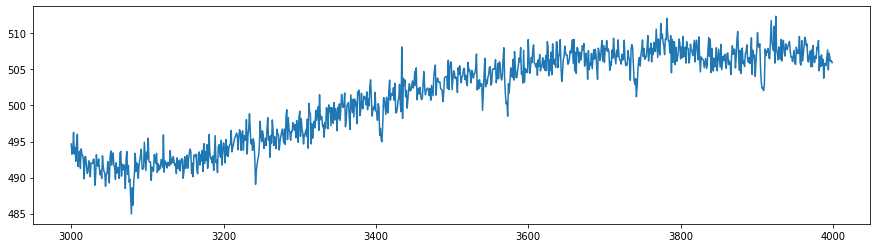

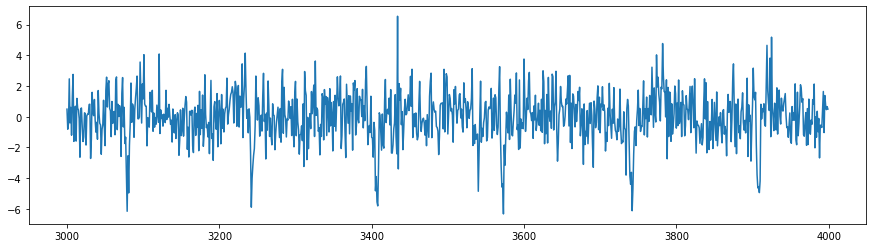

In [7]:
plt.figure(figsize=(15,4))
q = df[(df['quarter'] == 3) & (df['quarter_idx']==1)]['px2']
q.plot()

plt.figure(figsize=(15,4))
d = simple_detrending(q)
d.plot()

In [ ]:
# gerando o dataset

#lista de kepids ja processados
proc_lst = []
if dataset_control_path.exists():
    df = pd.read_parquet(dataset_control_path.resolve())
    proc_lst = df['kepid'].unique().tolist()


# lista de kepids processados e disposição "confirmados"
conf_idx = 0
conf_proc = []
for item in proc_lst:
    if item in conf_list:
        conf_proc.append(item)


# lista de kepids processados e disposição "falso p"
false_idx = 0
false_proc = []
for item in proc_lst:
    if item in fls_pos_list:
        false_proc.append(item)

print(f'Já foram processados {len(conf_proc)} confirmados e {len(false_proc)} falsos positivos\n')

if len(conf_proc) > len(false_proc):
    process = 'false_p'
else:
    process = 'confirm'

while process != 'exit':
    
    # salva confirmado
    while process == 'confirm':
        if conf_list[conf_idx] in conf_proc:
            if conf_idx + 1 < len(conf_list):
                conf_idx += 1
                continue
            else:
                process = 'exit'
                break
            
        r = save_kepid_datasets(conf_list[conf_idx], 'CONFD')
        if r == 'ok':
            conf_proc.append(conf_list[conf_idx])
            conf_idx += 1
            process = 'false_p'
            break
        if r == 'break':
            process = 'exit'
            break
            
    # salva falso p
    while process == 'false_p':
        if fls_pos_list[false_idx] in false_proc:
            if false_idx + 1 < len(fls_pos_list):
                false_idx += 1
                continue
            else:
                process = 'exit'
                break
        r = save_kepid_datasets(fls_pos_list[false_idx], 'FALSE')
        if r == 'ok':
            false_proc.append(fls_pos_list[false_idx])
            false_idx += 1
            process = 'confirm'
            break
        if r == 'break':
            process = 'exit'
            break
    

Já foram processados 195 confirmados e 194 falsos positivos

KEPID 7802136 Disposition FALSE
7802136 FALSE retornou 17 quartis
Quartil 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Do objeto de interesse 7802136, foram salvos 42 pedaços de quartis

KEPID 11193263 Disposition CONFD
11193263 CONFD retornou 17 quartis
Quartil 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Do objeto de interesse 11193263, foram salvos 46 pedaços de quartis

KEPID 9632895 Disposition FALSE
9632895 FALSE retornou 18 quartis
Quartil 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Do objeto de interesse 9632895, foram salvos 10 pedaços de quartis

KEPID 11027624 Disposition CONFD
11027624 CONFD retornou 18 quartis
Quartil 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Do objeto de interesse 11027624, foram salvos 46 pedaços de quartis

KEPID 7449844 Disposition FALSE
7449844 FALSE retornou 17 quartis
Quartil 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
Do objeto de interesse 7449844, foram salvos 47 pedaços de quartis

KEPID 1103222